In [1]:
import numpy as np
import pickle
import lzma

import elephant.statistics as estats
import elephant
import neo
from quantities import ms, s, Hz

from elephant.spike_train_dissimilarity import victor_purpura_distance
from elephant.spike_train_dissimilarity import van_rossum_distance

import pandas as pd
import matplotlib.pyplot as plt

import multiprocessing

import random
import seaborn as sns



In [2]:
# with open("./savedoutput/" + "FeedForward_point_layercount30_model0_input0_stddelay0.75_meandelay2.0_nrun8" + ".pkl", "rb") as fp:
#     out1 = pickle.load(fp)
# with open("./savedoutput/" + "FeedForward_point_layercount30_model0_input0_stddelay0.75_meandelay2.0_nrun9" + ".pkl", "rb") as fp:
#     out2 = pickle.load(fp)


# with lzma.open("./savedoutput/" + "SmallWorld_point_layercount30_model5_input0_stddelay1.0_meandelay3.0_nrun9" + ".xz", "rb") as fp:
#     out1 = pickle.load(fp)
# with lzma.open("./savedoutput/" + "SmallWorld_point_layercount30_model5_input0_stddelay1.0_meandelay3.0_nrun8" + ".xz", "rb") as fp:
#     out2 = pickle.load(fp)

In [3]:
# plt.figure(figsize=(40,10))
# plt.vlines(out1[5], 1 + 0.5, 1 + 1.5)
# plt.vlines(out2[5], 2 + 0.5, 2 + 1.5)

In [4]:
# for model_id in np.arange(0, 10, 1):
#     for input_idx in range(10):
#         for n_run in np.arange(0, 10, 1):
            
def get_data(networktype, layercount, meandelay, stddelay, model_id, input_idx, n_run, CellType = "point"):
    name = networktype + '_' + str(CellType) + '_layercount' + str(layercount) + '_model' + str(model_id) + '_input' + str(input_idx) + '_stddelay' + str(stddelay) + '_meandelay' + str(meandelay) + '_nrun' + str(n_run)
    with lzma.open("./savedoutput/" + name + ".xz", "rb") as fp:
        outsaved = pickle.load(fp)
    return outsaved

def get_vp(baseline, distrubed, qnum):
    # Calculating the victor purpora distace of a single cell spiking
    duration = 10000
    train1 = neo.SpikeTrain(baseline * ms, t_stop=duration*ms)
    train2 = neo.SpikeTrain(distrubed * ms, t_stop=duration*ms)
    
    # q = 1.0 / (10.0 * ms) # used in other paper
    q = qnum / ms # cost factor for shifting spikes in the victor purpura distance
    vp_dist = victor_purpura_distance([train1, train2], q)[0, 1]
    
    
    if len(baseline) == 0:
        return 0
    return vp_dist/ len(baseline)

def get_vr(baseline, distrubed, taunum):
    # Calculating the van rossum distace of a single cell spiking
    duration = 10000
    train1 = neo.SpikeTrain(baseline * ms, t_stop=duration*ms)
    train2 = neo.SpikeTrain(distrubed * ms, t_stop=duration*ms)
  
    # tau = 1s default? 10ms   why 10ms, vab rissom paper
    # tau = 10.0 * ms # time constant for the van rossum distance
    tau = 1000 * taunum * ms
    vr_dist = van_rossum_distance([train1, train2], tau)[0, 1]
    
    if len(baseline) == 0:
        return 0
    return vr_dist/ len(baseline)

# def get_devarvp(baseline, distrubed, qnum, stddelay):
#     # Calculating the devarianced victor purpora distace of a single cell spiking
#     duration = 10000
#     train1 = neo.SpikeTrain(baseline * ms, t_stop=duration*ms)
#     train2 = neo.SpikeTrain(distrubed * ms, t_stop=duration*ms)
#     # q = 1.0 / (10.0 * ms)
#     q = qnum / ms # cost factor for shifting spikes in the victor purpura distance
#     vp_dist = victor_purpura_distance([train1, train2], q)[0, 1]
#     # tau = 10.0 * ms # time constant for the van rossum distance
#     # vr_dist = van_rossum_distance([train1, train2], tau)[0, 1]
#     if len(baseline) == 0:
#         return 0
#     return (vp_dist - qnum * len(baseline) * stddelay * np.sqrt(2/np.pi)) / len(baseline)

def get_vp_singlerun(baseline_all, distrubed_all, qnum, stddelay, layercount):
    # Getting the vp metrics between layers of network of a single simulation
    avgvp_bylayer = []
    # avgdevarvp_bylayer = []
    for layer_num in range(10):
        layer_vp = []
        # layer_devarvp = []
        for cell_num in range(layercount):
            baseline = baseline_all[layer_num * layercount + cell_num]
            distrubed = distrubed_all[layer_num * layercount + cell_num]
            cell_vp = get_vp(baseline, distrubed, qnum)
            # cell_devarvp = get_devarvp(baseline, distrubed, qnum, stddelay)
            layer_vp.append(cell_vp)
            # layer_devarvp.append(cell_devarvp)
        avgvp_bylayer.append(np.mean(layer_vp))
        # avgdevarvp_bylayer.append(np.mean(layer_devarvp))
    # return np.array(avgvp_bylayer), np.array(avgdevarvp_bylayer)
    return np.array(avgvp_bylayer)

def get_vr_singlerun(baseline_all, distrubed_all, taunum, stddelay, layercount):
    # Getting the vp metrics between layers of network of a single simulation
    avgvp_bylayer = []
    # avgdevarvp_bylayer = []
    for layer_num in range(10):
        layer_vp = []
        # layer_devarvp = []
        for cell_num in range(layercount):
            baseline = baseline_all[layer_num * layercount + cell_num]
            distrubed = distrubed_all[layer_num * layercount + cell_num]
            cell_vp = get_vr(baseline, distrubed, taunum)
            # cell_devarvp = get_devarvp(baseline, distrubed, qnum, stddelay)
            layer_vp.append(cell_vp)
            # layer_devarvp.append(cell_devarvp)
        avgvp_bylayer.append(np.mean(layer_vp))
        # avgdevarvp_bylayer.append(np.mean(layer_devarvp))
    # return np.array(avgvp_bylayer), np.array(avgdevarvp_bylayer)
    return np.array(avgvp_bylayer)
    
        
def cal_VPbyStd(networktype, layercount, meandelay, stddelay, qnum):
    all_vp = []
    # all_devarvp = []
    for model_id in np.arange(0, 10, 1):
        for input_idx in range(10):
            baseline_all = get_data(networktype, layercount, meandelay, 0.0, model_id, input_idx, 0, CellType = "point")
            for n_run in np.arange(0, 10, 1): 
                distrubed_all = get_data(networktype, layercount, meandelay, stddelay, model_id, input_idx, n_run, CellType = "point")
                # singlerun_vp, singlerun_devarvp = get_vps_singlerun(baseline_all, distrubed_all, qnum, stddelay, layercount)
                singlerun_vp = get_vp_singlerun(baseline_all, distrubed_all, qnum, stddelay, layercount)
                all_vp.append(singlerun_vp)
                # all_devarvp.append(singlerun_devarvp)
    with open('./VP_processing/'+ networktype + "_layercount" + str(layercount) + "_meandelay" + str(meandelay) + "_stddelay" + str(stddelay) + "_qum" + str(qnum) + "_VP.pkl",'wb') as f: pickle.dump(all_vp, f)
    # with open('./VP_processing/'+ networktype + "_layercount" + str(layercount) + "_meandelay" + str(meandelay) + "_stddelay" + str(stddelay) + "_qum" + str(qnum) + "_devarVP.pkl",'wb') as f: pickle.dump(all_devarvp, f)
    return 0

def cal_VRbyStd(networktype, layercount, meandelay, stddelay, taunum):
    all_vp = []
    # all_devarvp = []
    for model_id in np.arange(0, 10, 1):
        for input_idx in range(10):
            baseline_all = get_data(networktype, layercount, meandelay, 0.0, model_id, input_idx, 0, CellType = "point")
            for n_run in np.arange(0, 10, 1): 
                distrubed_all = get_data(networktype, layercount, meandelay, stddelay, model_id, input_idx, n_run, CellType = "point")
                # singlerun_vp, singlerun_devarvp = get_vps_singlerun(baseline_all, distrubed_all, qnum, stddelay, layercount)
                singlerun_vp = get_vr_singlerun(baseline_all, distrubed_all, taunum, stddelay, layercount)
                all_vp.append(singlerun_vp)
                # all_devarvp.append(singlerun_devarvp)
    with open('./VR_processing/'+ networktype + "_layercount" + str(layercount) + "_meandelay" + str(meandelay) + "_stddelay" + str(stddelay) + "_tau" + str(taunum) + "_VR.pkl",'wb') as f: pickle.dump(all_vp, f)
    # with open('./VP_processing/'+ networktype + "_layercount" + str(layercount) + "_meandelay" + str(meandelay) + "_stddelay" + str(stddelay) + "_qum" + str(qnum) + "_devarVP.pkl",'wb') as f: pickle.dump(all_devarvp, f)
    return 0

def cal_VPbyStd_dicinput(input_dic):
    output = cal_VPbyStd(input_dic['networktype'], input_dic['layercount'], input_dic['meandelay'], input_dic['stddelay'], input_dic['qnum'])
    return 0

def cal_VRbyStd_dicinput(input_dic):
    output = cal_VRbyStd(input_dic['networktype'], input_dic['layercount'], input_dic['meandelay'], input_dic['stddelay'], input_dic['taunum'])
    return 0
                


        
        

In [5]:
# argdict_lst_vp = []
# argdict_lst_vr = []
# for layercount in [30, 40, 50, 60]:
#     for MeanDelay_noround in np.arange(2, 3.01, 0.2):
#         MeanDelay = np.round(MeanDelay_noround,1)
#         for stdDelay_noround in np.arange(0, 1.01, 0.05):
#             stdDelay = np.round(stdDelay_noround,2)
#             argdict_vp = {'networktype':'FeedForward', 'layercount':layercount , 'meandelay':MeanDelay, 'stddelay':stdDelay, 'qnum':0.1}
#             argdict_lst_vp.append(argdict_vp)
#             argdict_vr = {'networktype':'FeedForward', 'layercount':layercount , 'meandelay':MeanDelay, 'stddelay':stdDelay, 'taunum':0.01}
#             argdict_lst_vr.append(argdict_vr)
#             # cal_VPbyStd('FeedForward', layercount, MeanDelay, stdDelay, 0.1)
#             # cal_VRbyStd('FeedForward', layercount, MeanDelay, stdDelay, 0.01)

            

    

In [6]:
# len(argdict_lst_vr)


In [7]:
# cal_VRbyStd_dicinput(argdict_lst_vr[0])
# cal_VPbyStd_dicinput(argdict_lst_vp[0])

In [8]:
# with multiprocessing.Pool(processes=2) as pool:
#     output = pool.map(cal_VRbyStd_dicinput, argdict_lst_vr)
#     output = pool.map(cal_VPbyStd_dicinput, argdict_lst_vp)

In [9]:
data1 = get_data('FeedForward', 30, 2.6, 0.0, 3, 8, 0, CellType = "point")
data2 = get_data('FeedForward', 30, 2.6, 0.55, 3, 8, 7, CellType = "point")
get_vp_singlerun(data1, data2, 0.1, 0.55, 30)
# FeedForward_point_layercount30_model3_input8_stddelay0.55_meandelay2.6_nrun7.xz
# FeedForward_point_layercount30_model3_input8_stddelay0.55_meandelay2.6_nrun0.xz

array([0.        , 0.27370508, 0.61890213, 0.90101356, 0.89705025,
       0.99106113, 0.96008782, 0.94441753, 0.99893467, 1.00732122])

In [10]:
VP_lst = []
VR_lst = []
for i in range(10000):
    if i % 1000 == 0:
        print(i)
    num_spike1 = random.randint(300, 500)
    random_float1 = [random.uniform(0, 10000) for _ in range(num_spike1)]
    random_float1.sort()
    random_float2 = [random.uniform(0, 10000) for _ in range(num_spike1)]
    random_float2.sort()
    VP_lst.append(get_vp(random_float1, random_float2, 0.1))
    VR_lst.append(get_vr(random_float1, random_float2, 0.01))
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


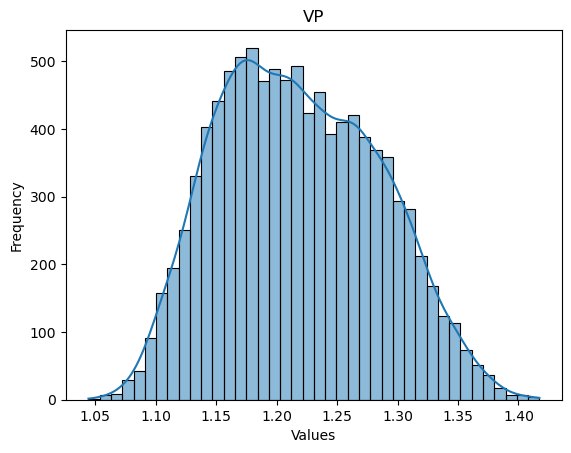

In [11]:
sns.histplot(VP_lst, kde=True)  # kde=True adds a kernel density estimate curve
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('VP')
plt.show()

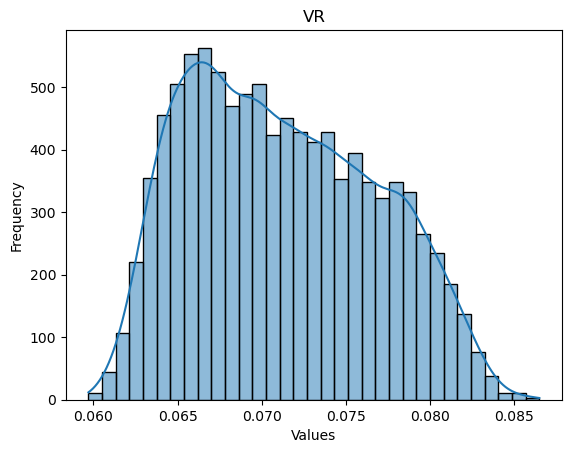

In [12]:
sns.histplot(VR_lst, kde=True)  # kde=True adds a kernel density estimate curve
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('VR')
plt.show()

In [ ]:
get_vr_singlerun(data1, data2, 0.1, 0.55, 30)

In [ ]:
# data1[1]

In [ ]:
vp1, devarvp1 = cal_VPbyStd('FeedForward', 30, 2.6, 0.55, 0.1)

In [ ]:
np.array(vp1).mean(axis  = 0)

In [ ]:
# def get_data(nlevel, n, MeanDelay):
#     result_dict = {}
#     for stdDelay_noround in np.arange(0, 1.01, 0.05):
#         stdDelay = np.round(stdDelay_noround,2)
#         for model_id in np.arange(0, 3, 1):
#             node_level_num = []
#             for ii in range(nlevel):
#                 node_level_num.append(n * 2)
#             node_level_num.append(n)
#             node_level_num.append(1)
#             CellType = "point"
#             for n_run in np.arange(0, 10, 1):
#                 name = str(node_level_num) + '_' + str(CellType) + '_' + str(MeanDelay) + '_' + str(stdDelay) + '_' + str(model_id) + '_' + str(n_run)
#                 with open("./savedoutput/" + name + ".pkl", "rb") as fp:
#                     outsaved = pickle.load(fp)
#                 result_dict[str(stdDelay) + '_' + str(model_id) + '_' + str(n_run)] = outsaved[-1]
#     return result_dict

# def get_vp(baseline, distrubed, qnum):
#     duration = 10000
#     train1 = neo.SpikeTrain(baseline * ms, t_stop=duration*ms)
#     train2 = neo.SpikeTrain(distrubed * ms, t_stop=duration*ms)
#     # q = 1.0 / (10.0 * ms) # cost factor for shifting spikes in the victor purpura distance
#     q = qnum / ms
#     tau = 10.0 * ms # time constant for the van rossum distance
#     vp_dist = victor_purpura_distance([train1, train2], q)[0, 1]
#     # vr_dist = van_rossum_distance([train1, train2], tau)[0, 1]
#     return vp_dist/ len(baseline)

# def get_devarvp(baseline, distrubed, qnum, stdnum):
#     duration = 10000
#     train1 = neo.SpikeTrain(baseline * ms, t_stop=duration*ms)
#     train2 = neo.SpikeTrain(distrubed * ms, t_stop=duration*ms)
#     # q = 1.0 / (10.0 * ms) # cost factor for shifting spikes in the victor purpura distance
#     q = qnum / ms
#     tau = 10.0 * ms # time constant for the van rossum distance
#     vp_dist = victor_purpura_distance([train1, train2], q)[0, 1]
#     # vr_dist = van_rossum_distance([train1, train2], tau)[0, 1]
#     return (vp_dist - qnum * len(baseline) * stdnum * np.sqrt(2/np.pi)) / len(baseline)


# def cal_VPbyStd(nlevel, n, MeanDelay, qnum):
#     output = get_data(nlevel, n, MeanDelay)
#     # baseline = output[list(output.keys())[0]]
#     vp_bystd = []
#     devarvp_bystd = []
#     for stdDelay_noround in np.arange(0.0, 1.01, 0.05):
#         stdDelay = np.round(stdDelay_noround,2)
#         vp_lst = []
#         devarvp_lst = []
#         for model_id in np.arange(0, 3, 1):
#             for n_run in np.arange(0, 10, 1):
#                 baseline_dickey = str(0.0) + "_" + str(model_id) + "_" + str(n_run)
#                 baseline = output[baseline_dickey]
#                 distrubed_dickey = str(stdDelay) + "_" + str(model_id) + "_" + str(n_run)
#                 distrubed = output[distrubed_dickey]
#                 # print(baseline_dickey, distrubed_dickey)
#                 vp_lst.append(get_vp(baseline, distrubed, qnum))
#                 devarvp_lst.append(get_devarvp(baseline, distrubed, qnum, stdDelay))
        
#         vp_bystd.append(np.mean(vp_lst))
#         devarvp_bystd.append(np.mean(vp_lst))
#     return vp_bystd, devarvp_bystd

# def cal_VPbyStd_singleparam(param):
#     return cal_VPbyStd(param['nlevel'], param['n'], param['MeanDelay'], param['qnum'])

# nlevel = 5
# n = 35
# MeanDelay = 2.6
# output = get_data(nlevel, n, MeanDelay)

# get_vp(output['0.0_0_0'], output['0.5_0_2'], 0.01)
# get_devarvp(output['0.0_0_0'], output['0.5_0_2'], 0.01, 0.5)

# print(len(output['0.0_0_0']))
# print(len(output['0.1_0_0']))


# plt.figure(figsize=(40,10))
# plt.vlines(output['0.0_0_0'], 1 + 0.5, 1 + 1.5)
# plt.vlines(output['0.1_0_0'], 2 + 0.5, 2 + 1.5)

In [ ]:
# nlevel_lst = []
# n_lst = []
# MeanDelay_lst = []
# qnum_lst = []
# param_lst = []

# vp_lst = []
# devarVP_lst = []

# for nlevel in np.arange(1, 10):
#     for n in np.arange(30, 41, 5):
#         for MeanDelay_noround in np.arange(2, 3.01, 0.2):
#             for qnum in [0, 0.1, 0.01, 0.001]:
#                 MeanDelay = np.round(MeanDelay_noround,1)
#                 print(nlevel, n, MeanDelay)
#                 nlevel_lst.append(nlevel)
#                 n_lst.append(n)
#                 MeanDelay_lst.append(MeanDelay)
#                 qnum_lst.append(qnum)
#                 param_lst.append({'nlevel':nlevel , 'n':n , 'MeanDelay':MeanDelay , 'qnum':qnum})
                
#                 vpp = cal_VPbyStd(nlevel, n, MeanDelay, qnum)
#                 vp_lst.append(vpp[0])
#                 devarVP_lst.append(vpp[1])
         
# ## with Pool(4) as p:
# #     vpp_lst = p.map(cal_VPbyStd_singleparam, param_lst)
# # for i in vpp_lst:
# #     devarVP_lst.append[i[0]]

In [ ]:

# df = pd.DataFrame(list(zip(nlevel_lst, n_lst, MeanDelay_lst, qnum_lst, vp_lst, devarVP_lst)),
#                columns =['nlevel', 'n', 'MeanDelay', 'qnum','vpbystd', 'devarVPbyStd'])

# df.to_pickle("VPbyStd_avg.pkl")
# df = pd.read_pickle('VPbyStd_avg.pkl')

In [ ]:
# std_delay_lst = []
# for stdDelay_noround in np.arange(0.0, 1.01, 0.05):
#         stdDelay = np.round(stdDelay_noround,2)
#         std_delay_lst.append(stdDelay)


In [ ]:
# df



In [ ]:
# # for cost = 0/ms but missing is 1
# fig, axs = plt.subplots(3, 6, figsize=(40, 20))
# counter_i = -1
# for n in np.arange(30, 41, 5):
#     counter_i += 1 
    
#     counter_j = -1
#     for MeanDelay_noround in np.arange(2, 3.01, 0.2):
#         MeanDelay = np.round(MeanDelay_noround,1)
#         counter_j += 1
#         for nlevel in np.arange(1, 5):
#             y = df.loc[(df['nlevel'] == nlevel) & (df['n'] == n) & (df['MeanDelay'] == MeanDelay)& (df['qnum'] == 0.001), 'vpbystd'].values[0]
#             axs[counter_i, counter_j].plot(std_delay_lst, y,  label=str(nlevel + 1) + ' layers')
#             axs[counter_i, counter_j].set_title('{} cells/layer,MeanDelay {}'.format(2 * n, MeanDelay))
#             axs[counter_i, counter_j].legend()
        

In [ ]:
# for cost = 0/ms but missing is 1
fig, axs = plt.subplots(3, 6, figsize=(40, 20))
counter_i = -1
for n in np.arange(30, 41, 5):
    counter_i += 1 
    
    counter_j = -1
    for MeanDelay_noround in np.arange(2, 3.01, 0.2):
        MeanDelay = np.round(MeanDelay_noround,1)
        counter_j += 1
        for nlevel in np.arange(1, 5):
            y = df.loc[(df['nlevel'] == nlevel) & (df['n'] == n) & (df['MeanDelay'] == MeanDelay)& (df['qnum'] == 0.1), 'vpbystd'].values[0]
            axs[counter_i, counter_j].plot(std_delay_lst, y,  label=str(nlevel + 1) + ' layers')
            axs[counter_i, counter_j].set_title('{} cells/layer,MeanDelay {}'.format(2 * n, MeanDelay))
            axs[counter_i, counter_j].legend()
        

In [ ]:
# # for cost = 0/ms but missing is 1
# fig, axs = plt.subplots(3, 6, figsize=(40, 20))
# counter_i = -1
# for n in np.arange(30, 41, 5):
#     counter_i += 1 
    
#     counter_j = -1
#     for MeanDelay_noround in np.arange(2, 3.01, 0.2):
#         MeanDelay = np.round(MeanDelay_noround,1)
#         counter_j += 1
#         for nlevel in np.arange(1, 5):
#             y = df.loc[(df['nlevel'] == nlevel) & (df['n'] == n) & (df['MeanDelay'] == MeanDelay)& (df['qnum'] == 0.1), 'devarVPbyStd'].values[0]
#             axs[counter_i, counter_j].plot(std_delay_lst, y,  label=str(nlevel + 1) + ' layers')
#             axs[counter_i, counter_j].set_title('{} cells/layer,MeanDelay {}'.format(2 * n, MeanDelay))
#             axs[counter_i, counter_j].legend()
        

In [ ]:
# # for cost = 0/ms but missing is 1
# fig, axs = plt.subplots(3, 6, figsize=(40, 20))
# counter_i = -1
# for n in np.arange(30, 41, 5):
#     counter_i += 1 
    
#     counter_j = -1
#     for MeanDelay_noround in np.arange(2, 3.01, 0.2):
#         MeanDelay = np.round(MeanDelay_noround,1)
#         counter_j += 1
#         for nlevel in np.arange(1, 5):
#             y = df.loc[(df['nlevel'] == nlevel) & (df['n'] == n) & (df['MeanDelay'] == MeanDelay)& (df['qnum'] == 0.01), 'vpbystd'].values[0]
#             axs[counter_i, counter_j].plot(std_delay_lst, y,  label=str(nlevel + 1) + ' layers')
#             axs[counter_i, counter_j].set_title('{} cells/layer,MeanDelay {}'.format(2 * n, MeanDelay))
#             axs[counter_i, counter_j].legend()
        

In [ ]:
# # for cost = 0/ms but missing is 1
# fig, axs = plt.subplots(3, 6, figsize=(40, 20))
# counter_i = -1
# for n in np.arange(30, 41, 5):
#     counter_i += 1 
    
#     counter_j = -1
#     for MeanDelay_noround in np.arange(2, 3.01, 0.2):
#         MeanDelay = np.round(MeanDelay_noround,1)
#         counter_j += 1
#         for nlevel in np.arange(1, 5):
#             y = df.loc[(df['nlevel'] == nlevel) & (df['n'] == n) & (df['MeanDelay'] == MeanDelay)& (df['qnum'] == 0.01), 'devarVPbyStd'].values[0]
#             axs[counter_i, counter_j].plot(std_delay_lst, y,  label=str(nlevel + 1) + ' layers')
#             axs[counter_i, counter_j].set_title('{} cells/layer,MeanDelay {}'.format(2 * n, MeanDelay))
#             axs[counter_i, counter_j].legend()
        

In [ ]:
# # for cost = 0/ms but missing is 1
# fig, axs = plt.subplots(3, 6, figsize=(40, 20))
# counter_i = -1
# for n in np.arange(30, 41, 5):
#     counter_i += 1 
    
#     counter_j = -1
#     for MeanDelay_noround in np.arange(2, 3.01, 0.2):
#         MeanDelay = np.round(MeanDelay_noround,1)
#         counter_j += 1
#         for nlevel in np.arange(1, 5):
#             y = df.loc[(df['nlevel'] == nlevel) & (df['n'] == n) & (df['MeanDelay'] == MeanDelay)& (df['qnum'] == 0.001), 'devarVPbyStd'].values[0]
#             axs[counter_i, counter_j].plot(std_delay_lst, y,  label=str(nlevel + 1) + ' layers')
#             axs[counter_i, counter_j].set_title('{} cells/layer,MeanDelay {}'.format(2 * n, MeanDelay))
#             axs[counter_i, counter_j].legend()
        

In [ ]:
# for cost = 0/ms but missing is 1
fig, axs = plt.subplots(3, 6, figsize=(40, 20))
counter_i = -1
for n in np.arange(30, 41, 5):
    counter_i += 1 
    
    counter_j = -1
    for MeanDelay_noround in np.arange(2, 3.01, 0.2):
        MeanDelay = np.round(MeanDelay_noround,1)
        counter_j += 1
        for nlevel in np.arange(1, 5):
            y = df.loc[(df['nlevel'] == nlevel) & (df['n'] == n) & (df['MeanDelay'] == MeanDelay)& (df['qnum'] == 0), 'devarVPbyStd'].values[0]
            axs[counter_i, counter_j].plot(std_delay_lst, y,  label=str(nlevel + 1) + ' layers')
            axs[counter_i, counter_j].set_title('{} cells/layer,MeanDelay {}'.format(2 * n, MeanDelay))
            axs[counter_i, counter_j].legend()
        

In [ ]:
# for i in range(df.shape[0]):
#     # plt.figure()
#     name = (str(df.iloc[i,0]) + "_" + str(df.iloc[i,1]) + "_" + str(df.iloc[i,2]))
#     plt.plot(std_delay_lst, df.iloc[i,3], label=name)
#     plt.legend()
#     # plt.show()
    
    

In [ ]:
# over400lst = []
# for i in range(162):
#     if max(df.iloc[i, 3]) > 400:
#         over400lst.append(i)

In [ ]:
# for i in over400lst:
#     print(i)
#     print(df.iloc[i, :3])
#     plt.figure()
#     plt.plot(std_delay_lst, df.iloc[i,3])
#     plt.show()
    
    

In [ ]:
# for i in over400lst:
#     print(i)
#     print(df.iloc[i, :3])
#     print(calFulllist_VPbyStd(df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 2]))

In [ ]:
# for nlevel in np.arange(1, 10):
#     for n in np.arange(30, 41, 5):
#         for MeanDelay_noround in np.arange(2, 3.01, 0.2):
#             MeanDelay = np.round(MeanDelay_noround,1)
#             for stdDelay_noround in np.arange(0, 1.01, 0.1):
#                 stdDelay = np.round(stdDelay_noround,1)
#                 for model_id in np.arange(0, 5, 1):
#                     node_level_num = []
#                     for ii in range(nlevel):
#                         node_level_num.append(n * 2)
#                     node_level_num.append(n)
#                     node_level_num.append(1)
#                     CellType = "point"
#                     for n_run in np.arange(0, 5, 1):
#                         name = str(node_level_num) + '_' + str(CellType) + '_' + str(MeanDelay) + '_' + str(stdDelay) + '_' + str(model_id) + '_' + str(n_run)

In [ ]:
# get_vp(output[list(output.keys())[0]], output[list(output.keys())[13]])

In [ ]:
# name = '[70, 70, 35, 1]_point_2.0_0.0_0_0'
# with open("./savedoutput/" + name + ".pkl", "rb") as fp:
#     outsaved = pickle.load(fp)
# node_level_num = [int(_) for _ in name[1:].split(']')[0].split(',')]
# vec_space = 0.025
# spike_mat = np.zeros((len(outsaved), int(10000/vec_space)))
# for i in range(len(outsaved)):
#     for n in range(len(outsaved[i])):
#         j = int(outsaved[i][n]/vec_space)
#         spike_mat[i, j] = 1
# spike_mat_bylayer = []
# start_idx = 0
# end_idx = 0
# for n in node_level_num:
#     end_idx += n
#     spike_mat_bylayer.append(spike_mat[start_idx:end_idx,:])
#     start_idx += n

In [ ]:
# spikes = [10, 20, 30]
# duration = 50
# train1 = neo.SpikeTrain(spikes * ms, t_stop=duration*ms) # spikes is a list of spike times, duration is a float of duration of spike train

# spikes2 = [5, 33, 37]
# duration2 = 50
# train2 = neo.SpikeTrain(spikes2 * ms, t_stop=duration2*ms) # spikes is a list of spike times, duration is a float of duration of spike train

# q = 1.0 / (10.0 * ms) # cost factor for shifting spikes in the victor purpura distance
# tau = 10.0 * ms # time constant for the van rossum distance
# vp_dist = victor_purpura_distance([train1, train2], q)[0, 1]
# vr_dist = van_rossum_distance([train1, train2], tau)[0, 1]